<a href="https://colab.research.google.com/github/JonssonAlexander/Detecting_Construction_pipes/blob/main/Data_gathering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data gathering


The first step is to gather the data we need for training the model. Fortunately, we'll be using the Segment-Anything model to efficiently extract core images from complex pictures. Our ultimate goal is to download each segmented image and manually label them, which will allow us to train our AI.



To get started, let's import the necessary packages. Keep in mind that since Segment Anything is built on PyTorch, you'll need to run the program on a GPU. If this isn't possible, you can use Google Colab instead by visiting https://colab.research.google.com.

In [3]:
import torch
import torchvision
# The print statements are in order to ensure that we have the correct requirements installed. For requirements, please review the official 
#segment-anything documentation

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

# Check if CUDA is available
print("CUDA is available:", torch.cuda.is_available())
import sys
# Installing Segment Anything and the necessary model checkpoint
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-y310mkzk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-y310mkzk
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=7d947cea06c6f798467802cd76098e56aa4b40ddb586c6468d3f4d01176e0629
  Stored in directory: /tmp/pip-ephem-wheel-cache-p4480qe4/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything
--2023-04-16 22:22:22--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8

In [4]:
# Installing packages for visualisation
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from skimage.io import imread,imsave

In [5]:
image = cv2.imread('/content/image.jpeg') # Sample image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Making the image "openCV friendly"

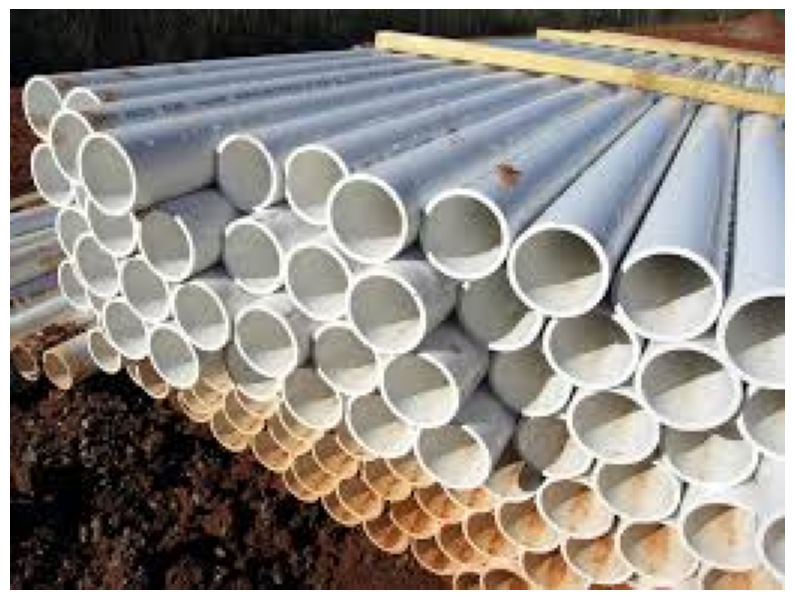

In [6]:
# Plot the sample image
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

Ok so we have the picture, now let's actually segment the image.

In [7]:
# Setting up the correct Segment Anything setup

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
masks = mask_generator.generate(image) # This line of code generates the masks for the image
df = pd.DataFrame.from_dict(masks)

In [9]:
print(f'Amount of segments: {len(df)}')

Amount of segments: 157


In [10]:
# Coloring the masks
def show_anns(annotations):
    if not annotations:
        return
    sorted_anns = sorted(annotations, key=lambda x: x['area'], reverse=True) # This puts the segmentations in descending order by size
    
    # Plotting
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for annotation in sorted_anns:
        mask = annotation['segmentation']
        color_mask = np.random.rand(3)
        color_image = np.tile(color_mask, (mask.shape[0], mask.shape[1], 1))
        ax.imshow(np.dstack((color_image, mask*0.35)))

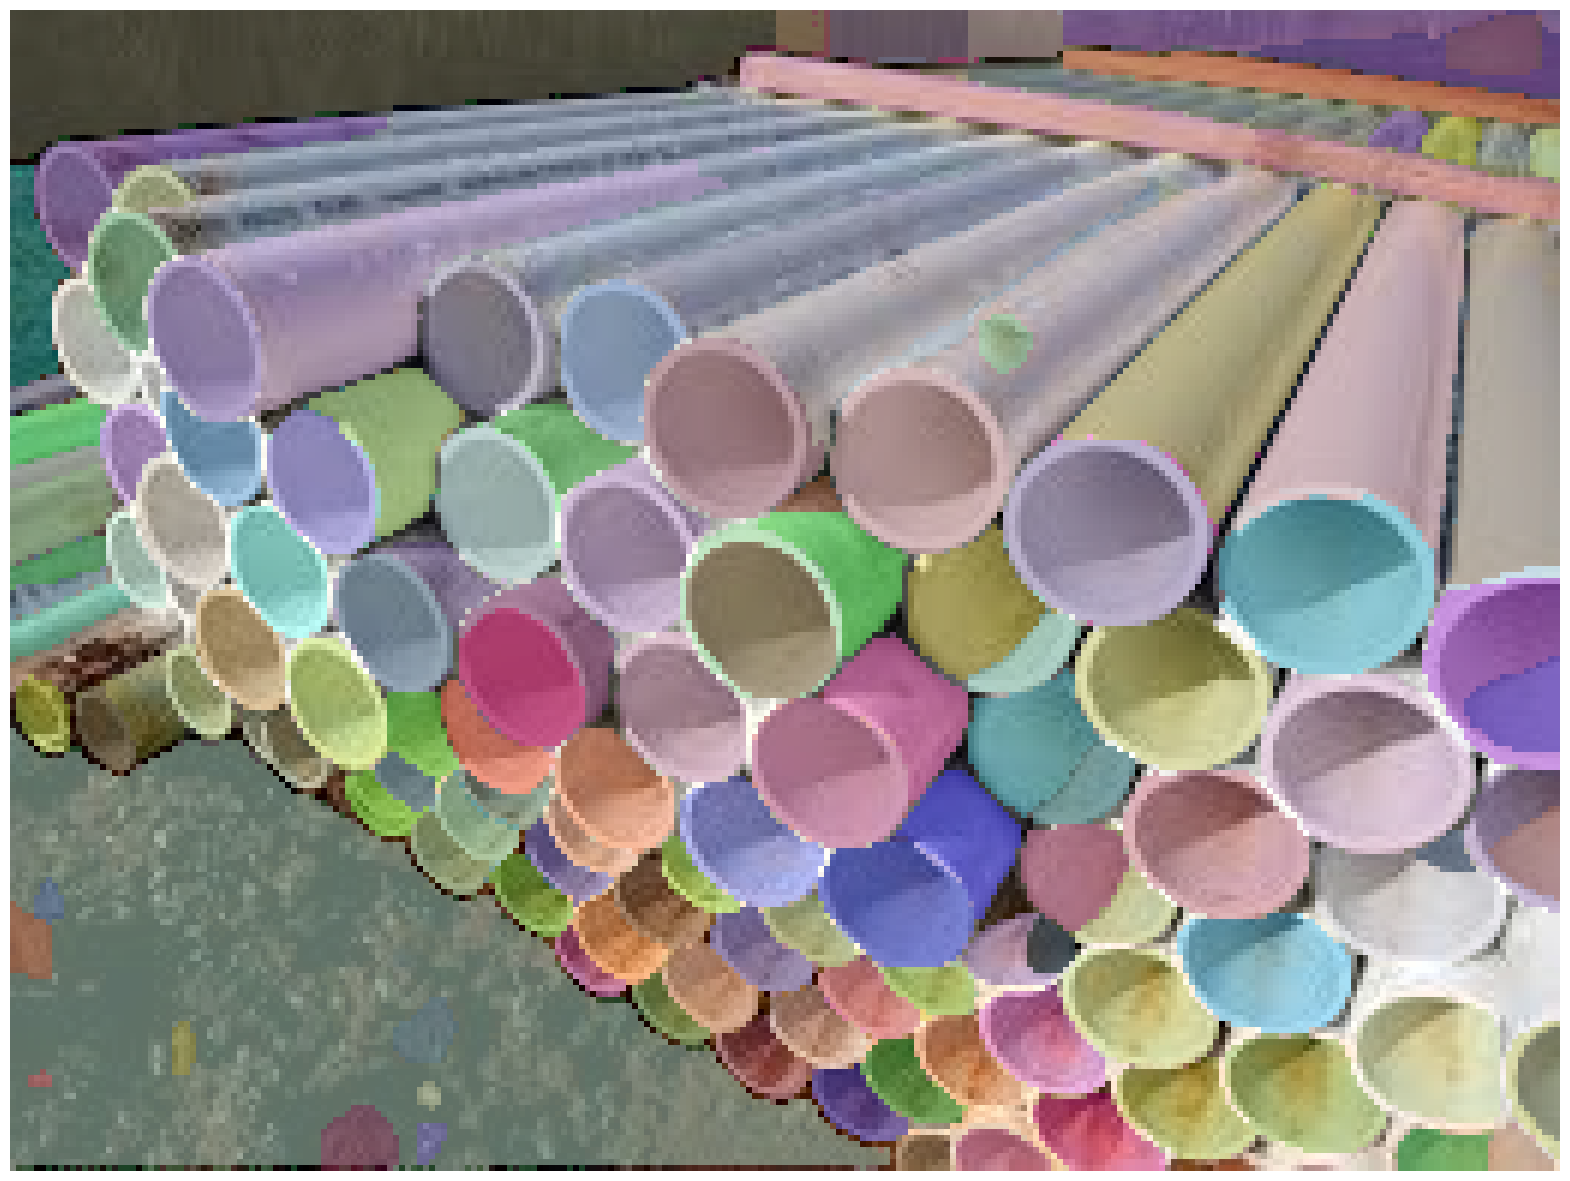

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
# Downloading the segmentations

def find_the_segmentation(index_):
    
  # Sort the segmentations in descending order by area
  sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
  print('the segmentation area has {} pixels'.format(sorted_anns[index_]['area']))

  # Extract the mask for the specified segmentation and convert it to an RGB image
  mask = np.expand_dims(sorted_anns[index_]['segmentation'], axis=-1)
  segmented_area = (image * mask).astype('uint8')
  segmented_area[segmented_area == 0] = 1
  segmented_area *= 255

  # Save the segmented area to a file
  imsave(f'/Reroute_images/object{index_}.png', segmented_area)



  for x in range(len(masks)):
    find_the_segmentation(x)

The segmented images are now saved to a file of our choice. Now we just need to label the data. 